# Structure embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [2]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From (uriginal): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
From (redirected): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756&confirm=t&uuid=602a0f65-3542-4767-a840-0406e26855d0
To: /Users/Henry/Documents/PyCharmProjects/PythonSimilarity/Embedding/Embedding_model_315/Evaluation/repo_info.pkl
100%|████████████████████████████████████████| 201M/201M [00:07<00:00, 25.4MB/s]


In [3]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [4]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
# !wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!curl -O https: // raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10352  100 10352    0     0  25802      0 --:--:-- --:--:-- --:--:-- 26075


In [5]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [6]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]

In [7]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer

unixcoder_models = {}
sentence_transformer_models = {}

# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

## 3. Generating structure embeddings

In [8]:
# Getting code embeddings
def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings


# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Unixcoder model
    #     for u_name, u_model in tqdm(unixcoder_models.items()):
    #         print(f" - Using {u_name} model - ")
    #         embeddings_list = torch.concat([get_code_embeddings(code, u_model) for code in data_list])
    #         embeddings[u_name] = torch.mean(embeddings_list, dim=0)
    # embeddings[u_name] = embeddings_list

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = torch.mean(embeddings_list, dim=0)
        # embeddings[s_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "structure":
            return get_other_embeddings(input_data)


In [9]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating structure embeddings for {repo_name} - ")
    repo_dict["structure_embeddings"] = get_embeddings(input_data=repo_dict["structure"], input_mode="structure")

  0%|                                                   | 0/315 [00:00<?, ?it/s]

 - Generating structure embeddings for jet-admin/jet-bridge - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.29it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.89it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.37it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.07it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



  0%|▏                                          | 1/315 [00:02<12:14,  2.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for patrys/httmock - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



  1%|▎                                          | 2/315 [00:02<05:28,  1.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pytransitions/transitions - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



  1%|▍                                          | 3/315 [00:02<03:14,  1.60it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for keleshev/schema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  1%|▌                                          | 4/315 [00:02<02:11,  2.36it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dylanaraps/pywal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  2%|▋                                          | 5/315 [00:02<01:37,  3.17it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PyCQA/modernize - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  2%|▊                                          | 6/315 [00:02<01:17,  3.98it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jaraco/path.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  2%|▉                                          | 7/315 [00:03<01:04,  4.79it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for xonsh/xonsh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█                                          | 8/315 [00:03<00:54,  5.65it/s]

 - Generating structure embeddings for python-excel/xlrd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  3%|█▏                                         | 9/315 [00:03<00:48,  6.26it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for cloudnativelabs/kube-shell - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  3%|█▎                                        | 10/315 [00:03<00:45,  6.70it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ironmussa/Optimus - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▍                                        | 11/315 [00:03<00:42,  7.16it/s]

 - Generating structure embeddings for jazzband/django-taggit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▌                                        | 12/315 [00:03<00:39,  7.58it/s]

 - Generating structure embeddings for moggers87/salmon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  4%|█▋                                        | 13/315 [00:03<00:37,  8.12it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for glamp/bashplotlib - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  4%|█▊                                        | 14/315 [00:03<00:36,  8.24it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PyCQA/prospector - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.90it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  5%|██                                        | 15/315 [00:04<00:47,  6.30it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for twisted/treq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.96it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  5%|██▏                                       | 16/315 [00:04<00:43,  6.87it/s]

 - Generating structure embeddings for bbangert/beaker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  5%|██▎                                       | 17/315 [00:04<00:41,  7.22it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pypa/bandersnatch - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  6%|██▍                                       | 18/315 [00:04<00:38,  7.65it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for zachwill/moment - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  6%|██▌                                       | 19/315 [00:04<00:37,  7.92it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for encode/apistar - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  6%|██▋                                       | 20/315 [00:04<00:36,  8.02it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pyinvoke/invoke - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▊                                       | 21/315 [00:04<00:35,  8.21it/s]

 - Generating structure embeddings for skorokithakis/shortuuid - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 48.47it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  7%|██▉                                       | 22/315 [00:04<00:35,  8.28it/s]

 - Generating structure embeddings for s3tools/s3cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 23.92it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  7%|███                                       | 23/315 [00:05<00:40,  7.21it/s]

 - Generating structure embeddings for pyenv/pyenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  8%|███▏                                      | 24/315 [00:05<00:38,  7.55it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for stchris/untangle - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███▎                                      | 25/315 [00:05<00:36,  7.90it/s]

 - Generating structure embeddings for nvdv/vprof - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.35it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  8%|███▍                                      | 26/315 [00:05<00:38,  7.60it/s]

 - Generating structure embeddings for h2oai/h2o-3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  9%|███▌                                      | 27/315 [00:05<00:36,  7.79it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for benhamner/Metrics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



  9%|███▋                                      | 28/315 [00:05<00:35,  7.98it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jmcarp/robobrowser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.82it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


  9%|███▊                                      | 29/315 [00:05<00:36,  7.89it/s]

 - Generating structure embeddings for WiserTogether/django-remote-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.89it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 10%|████                                      | 30/315 [00:06<00:35,  7.92it/s]

 - Generating structure embeddings for mahmoud/boltons - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 10%|████▏                                     | 31/315 [00:06<00:35,  8.09it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for stanfordnlp/stanza - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 10%|████▎                                     | 32/315 [00:06<00:34,  8.23it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for keon/algorithms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.08it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 10%|████▍                                     | 33/315 [00:06<00:35,  7.99it/s]

 - Generating structure embeddings for esnme/ultrajson - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 11%|████▌                                     | 34/315 [00:06<00:34,  8.18it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for boto/boto3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.05it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 11%|████▋                                     | 35/315 [00:06<00:35,  7.92it/s]

 - Generating structure embeddings for geopy/geopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.25it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 11%|████▊                                     | 36/315 [00:06<00:34,  8.04it/s]

 - Generating structure embeddings for sdispater/pendulum - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 12%|████▉                                     | 37/315 [00:06<00:34,  8.02it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for omab/python-social-auth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 12%|█████                                     | 38/315 [00:07<00:34,  8.04it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django-guardian/django-guardian - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 12%|█████▏                                    | 39/315 [00:07<00:33,  8.22it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mongodb/motor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.72it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 13%|█████▎                                    | 40/315 [00:07<00:33,  8.20it/s]

 - Generating structure embeddings for napalm-automation/napalm - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.23it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 13%|█████▍                                    | 41/315 [00:07<00:34,  8.05it/s]

 - Generating structure embeddings for django-crispy-forms/django-crispy-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 13%|█████▌                                    | 42/315 [00:07<00:33,  8.06it/s]

 - Generating structure embeddings for mymarilyn/clickhouse-driver - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 49.14it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 14%|█████▋                                    | 43/315 [00:07<00:33,  8.06it/s]

 - Generating structure embeddings for sdispater/orator - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 14%|█████▊                                    | 44/315 [00:07<00:33,  8.05it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for codelucas/newspaper - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 14%|██████                                    | 45/315 [00:07<00:33,  8.00it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for coleifer/huey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.83it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 15%|██████▏                                   | 46/315 [00:07<00:33,  7.98it/s]

 - Generating structure embeddings for sympy/sympy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|██████▎                                   | 47/315 [00:08<00:32,  8.30it/s]

 - Generating structure embeddings for gabrielfalcao/HTTPretty - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|██████▍                                   | 48/315 [00:08<00:32,  8.34it/s]

 - Generating structure embeddings for elapouya/python-docx-template - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.35it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 16%|██████▌                                   | 49/315 [00:08<00:31,  8.39it/s]

 - Generating structure embeddings for dahlia/wand - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 16%|██████▋                                   | 50/315 [00:08<00:31,  8.42it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mpdavis/python-jose - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 35.82it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 16%|██████▊                                   | 51/315 [00:08<00:33,  7.89it/s]

 - Generating structure embeddings for shinux/PyTime - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.89it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 17%|██████▉                                   | 52/315 [00:08<00:34,  7.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pymc-devs/pymc3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.11it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 17%|███████                                   | 53/315 [00:08<00:34,  7.63it/s]

 - Generating structure embeddings for TheAlgorithms/Python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.19it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 17%|███████▏                                  | 54/315 [00:09<00:34,  7.62it/s]

 - Generating structure embeddings for fabric/fabric - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.39it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 17%|███████▎                                  | 55/315 [00:09<00:34,  7.60it/s]

 - Generating structure embeddings for mindflayer/python-mocket - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.11it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 18%|███████▍                                  | 56/315 [00:09<00:34,  7.46it/s]

 - Generating structure embeddings for benfred/py-spy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.36it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 18%|███████▌                                  | 57/315 [00:09<00:34,  7.42it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mikeorr/Unipath - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 18%|███████▋                                  | 58/315 [00:09<00:34,  7.40it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for unoconv/unoconv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 19%|███████▊                                  | 59/315 [00:09<00:34,  7.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for google/google-api-python-client - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.54it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 19%|████████                                  | 60/315 [00:09<00:34,  7.45it/s]

 - Generating structure embeddings for sdispater/poetry - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 19%|████████▏                                 | 61/315 [00:09<00:34,  7.40it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dbader/schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 20%|████████▎                                 | 62/315 [00:10<00:34,  7.42it/s]

 - Generating structure embeddings for dimka665/awesome-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 20%|████████▍                                 | 63/315 [00:10<00:34,  7.41it/s]

 - Generating structure embeddings for timothycrosley/isort - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.71it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 20%|████████▌                                 | 64/315 [00:10<00:34,  7.36it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mobolic/facebook-sdk - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.47it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 21%|████████▋                                 | 65/315 [00:10<00:34,  7.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for wemake-services/wemake-python-styleguide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.44it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 21%|████████▊                                 | 66/315 [00:10<00:33,  7.34it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dirn/When.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.65it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 21%|████████▉                                 | 67/315 [00:10<00:33,  7.43it/s]

 - Generating structure embeddings for miso-belica/sumy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 22%|█████████                                 | 68/315 [00:10<00:33,  7.42it/s]

 - Generating structure embeddings for davidaurelio/hashids-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.40it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 22%|█████████▏                                | 69/315 [00:11<00:33,  7.43it/s]

 - Generating structure embeddings for noxrepo/pox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.74it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 22%|█████████▎                                | 70/315 [00:11<00:32,  7.46it/s]

 - Generating structure embeddings for sqlmapproject/sqlmap - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 23%|█████████▍                                | 71/315 [00:11<00:32,  7.52it/s]

 - Generating structure embeddings for errbotio/errbot - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 34.91it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 41.04it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|█████████▌                                | 72/315 [00:11<00:33,  7.26it/s]

 - Generating structure embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.86it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 23%|█████████▋                                | 73/315 [00:11<00:32,  7.38it/s]

 - Generating structure embeddings for jakubroztocil/httpie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.71it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 23%|█████████▊                                | 74/315 [00:11<00:34,  6.99it/s]

 - Generating structure embeddings for cdgriffith/Box - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 24%|██████████                                | 75/315 [00:11<00:34,  6.88it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for python-openxml/python-docx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.79it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 24%|██████████▏                               | 76/315 [00:12<00:33,  7.14it/s]

 - Generating structure embeddings for gleitz/howdoi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 24%|██████████▎                               | 77/315 [00:12<00:31,  7.64it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for vinta/pangu.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 25%|██████████▍                               | 78/315 [00:12<00:32,  7.37it/s]

 - Generating structure embeddings for derek73/python-nameparser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 25%|██████████▌                               | 79/315 [00:12<00:31,  7.53it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for cobrateam/splinter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.16it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 25%|██████████▋                               | 80/315 [00:12<00:31,  7.55it/s]

 - Generating structure embeddings for keras-team/keras - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.48it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 26%|██████████▊                               | 81/315 [00:12<00:31,  7.53it/s]

 - Generating structure embeddings for Pylons/deform - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 47.93it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 26%|██████████▉                               | 82/315 [00:12<00:30,  7.70it/s]

 - Generating structure embeddings for facebook/pyre-check - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.59it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 26%|███████████                               | 83/315 [00:12<00:30,  7.69it/s]

 - Generating structure embeddings for DiffSK/configobj - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.62it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 27%|███████████▏                              | 84/315 [00:13<00:29,  7.74it/s]

 - Generating structure embeddings for binux/pyspider - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.88it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 27%|███████████▎                              | 85/315 [00:13<00:29,  7.77it/s]

 - Generating structure embeddings for getnikola/nikola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 27%|███████████▍                              | 86/315 [00:13<00:29,  7.74it/s]

 - Generating structure embeddings for dask/dask - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 28%|███████████▌                              | 87/315 [00:13<00:29,  7.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mozilla/unicode-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 28%|███████████▋                              | 88/315 [00:13<00:29,  7.60it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for devsnd/tinytag - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 28%|███████████▊                              | 89/315 [00:13<00:30,  7.43it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jazzband/pip-tools - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 29%|████████████                              | 90/315 [00:13<00:30,  7.29it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gmr/queries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 29%|████████████▏                             | 91/315 [00:13<00:30,  7.30it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for getsentry/sentry-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 29%|████████████▎                             | 92/315 [00:14<00:30,  7.37it/s]

 - Generating structure embeddings for pallets/jinja - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 30%|████████████▍                             | 93/315 [00:14<00:30,  7.36it/s]

 - Generating structure embeddings for rkern/line_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 35.76it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 30%|████████████▌                             | 94/315 [00:14<00:30,  7.20it/s]

 - Generating structure embeddings for marrow/mailer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.41it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 30%|████████████▋                             | 95/315 [00:14<00:30,  7.32it/s]

 - Generating structure embeddings for gawel/pyquery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 30%|████████████▊                             | 96/315 [00:14<00:29,  7.37it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for spotify/luigi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 31%|████████████▉                             | 97/315 [00:14<00:29,  7.32it/s]

 - Generating structure embeddings for devpi/devpi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.89it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 31%|█████████████                             | 98/315 [00:14<00:29,  7.34it/s]

 - Generating structure embeddings for modoboa/modoboa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.65it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 31%|█████████████▏                            | 99/315 [00:15<00:29,  7.31it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for falconry/falcon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.93it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 32%|█████████████                            | 100/315 [00:15<00:29,  7.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django-cache-machine/django-cache-machine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 32%|█████████████▏                           | 101/315 [00:15<00:28,  7.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for martinrusev/imbox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.45it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 32%|█████████████▎                           | 102/315 [00:15<00:28,  7.37it/s]

 - Generating structure embeddings for lektor/lektor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.45it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 33%|█████████████▍                           | 103/315 [00:15<00:28,  7.38it/s]

 - Generating structure embeddings for spotify/annoy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.55it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 33%|█████████████▌                           | 104/315 [00:15<00:28,  7.35it/s]

 - Generating structure embeddings for lincolnloop/python-qrcode - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.99it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 33%|█████████████▋                           | 105/315 [00:15<00:27,  7.52it/s]

 - Generating structure embeddings for miracle2k/flask-assets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 27.29it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 34%|█████████████▊                           | 106/315 [00:16<00:30,  6.82it/s]

 - Generating structure embeddings for hhatto/nude.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 34%|█████████████▉                           | 107/315 [00:16<00:29,  7.05it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for timofurrer/maya - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 48.26it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|██████████████                           | 108/315 [00:16<00:28,  7.29it/s]

 - Generating structure embeddings for MicroPyramid/forex-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 35%|██████████████▏                          | 109/315 [00:16<00:28,  7.20it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for codeinthehole/purl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 61.13it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for khamidou/lptrace - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.51it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 35%|██████████████▍                          | 111/315 [00:16<00:26,  7.70it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for altair-viz/altair - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.17it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 36%|██████████████▌                          | 112/315 [00:16<00:26,  7.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jendrikseipp/vulture - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|██████████████▋                          | 113/315 [00:16<00:25,  7.83it/s]

 - Generating structure embeddings for Pylons/waitress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.44it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 36%|██████████████▊                          | 114/315 [00:17<00:26,  7.53it/s]

 - Generating structure embeddings for SerpentAI/SerpentAI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 37%|██████████████▉                          | 115/315 [00:17<00:26,  7.58it/s]

 - Generating structure embeddings for html5lib/html5lib-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 37%|███████████████                          | 116/315 [00:17<00:26,  7.62it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dmlc/mxnet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 18.03it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 37%|███████████████▏                         | 117/315 [00:17<00:30,  6.58it/s]

 - Generating structure embeddings for django-haystack/pysolr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 37%|███████████████▎                         | 118/315 [00:17<00:28,  6.84it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for aizvorski/scikit-video - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 38%|███████████████▍                         | 119/315 [00:17<00:27,  7.10it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sergree/matchering - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 38%|███████████████▌                         | 120/315 [00:17<00:25,  7.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ZoomerAnalytics/xlwings - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 38%|███████████████▋                         | 121/315 [00:18<00:25,  7.69it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jazzband/django-pipeline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.65it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 39%|███████████████▉                         | 122/315 [00:18<00:24,  7.73it/s]

 - Generating structure embeddings for clips/pattern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 39%|████████████████                         | 123/315 [00:18<00:24,  8.00it/s]

 - Generating structure embeddings for fabianp/memory_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 39%|████████████████▏                        | 124/315 [00:18<00:24,  7.79it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mitsuhiko/unp - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 40%|████████████████▎                        | 125/315 [00:18<00:23,  8.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for stephenmcd/hot-redis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.09it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 40%|████████████████▍                        | 126/315 [00:18<00:24,  7.71it/s]

 - Generating structure embeddings for henriquebastos/python-decouple - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.82it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 40%|████████████████▌                        | 127/315 [00:18<00:25,  7.45it/s]

 - Generating structure embeddings for marshmallow-code/webargs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|████████████████▋                        | 128/315 [00:18<00:24,  7.68it/s]

 - Generating structure embeddings for flask-api/flask-api - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 41%|████████████████▊                        | 129/315 [00:19<00:23,  7.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ansible/ansible - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 41%|████████████████▉                        | 130/315 [00:19<00:23,  7.85it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for amitt001/delegator.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.76it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 42%|█████████████████                        | 131/315 [00:19<00:24,  7.53it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for SavinaRoja/PyUserInput - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|█████████████████▏                       | 132/315 [00:19<00:23,  7.86it/s]

 - Generating structure embeddings for MongoEngine/mongoengine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.90it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 42%|█████████████████▎                       | 133/315 [00:19<00:23,  7.78it/s]

 - Generating structure embeddings for pybee/toga - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.98it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 43%|█████████████████▍                       | 134/315 [00:19<00:23,  7.74it/s]

 - Generating structure embeddings for google/yapf - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.77it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 43%|█████████████████▌                       | 135/315 [00:19<00:24,  7.44it/s]

 - Generating structure embeddings for Fizzadar/pyinfra - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 43%|█████████████████▋                       | 136/315 [00:20<00:23,  7.49it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for istrategylabs/django-wordpress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.64it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 43%|█████████████████▊                       | 137/315 [00:20<00:23,  7.57it/s]

 - Generating structure embeddings for zopefoundation/ZODB - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 44%|█████████████████▉                       | 138/315 [00:20<00:23,  7.59it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for boppreh/mouse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.96it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 44%|██████████████████                       | 139/315 [00:20<00:23,  7.56it/s]

 - Generating structure embeddings for justquick/django-activity-stream - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 44%|██████████████████▏                      | 140/315 [00:20<00:23,  7.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for benoitc/gunicorn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 35.73it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 45%|██████████████████▎                      | 141/315 [00:20<00:23,  7.30it/s]

 - Generating structure embeddings for prabhupant/python-ds - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 45%|██████████████████▍                      | 142/315 [00:20<00:23,  7.27it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for marshmallow-code/marshmallow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.09it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 45%|██████████████████▌                      | 143/315 [00:20<00:23,  7.28it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for coleifer/micawber - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.71it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 46%|██████████████████▋                      | 144/315 [00:21<00:23,  7.20it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for getsentry/responses - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.05it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 46%|██████████████████▊                      | 145/315 [00:21<00:23,  7.23it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for joestump/python-oauth2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.97it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 46%|███████████████████                      | 146/315 [00:21<00:23,  7.25it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for chapmanb/bcbb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.67it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 47%|███████████████████▏                     | 147/315 [00:21<00:22,  7.31it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Cornices/cornice - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.85it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 47%|███████████████████▎                     | 148/315 [00:21<00:22,  7.37it/s]

 - Generating structure embeddings for mozilla/bleach - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.38it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 47%|███████████████████▍                     | 149/315 [00:21<00:22,  7.45it/s]

 - Generating structure embeddings for selwin/python-user-agents - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.73it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 48%|███████████████████▌                     | 150/315 [00:21<00:22,  7.47it/s]

 - Generating structure embeddings for Suor/django-cacheops - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.64it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 48%|███████████████████▋                     | 151/315 [00:22<00:21,  7.47it/s]

 - Generating structure embeddings for burnash/gspread - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.73it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 48%|███████████████████▊                     | 152/315 [00:22<00:21,  7.46it/s]

 - Generating structure embeddings for chapmanb/bcbio-nextgen - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.55it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 49%|███████████████████▉                     | 153/315 [00:22<00:21,  7.47it/s]

 - Generating structure embeddings for django/daphne - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.60it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 49%|████████████████████                     | 154/315 [00:22<00:21,  7.43it/s]

 - Generating structure embeddings for stephenmcd/mezzanine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.37it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 49%|████████████████████▏                    | 155/315 [00:22<00:21,  7.29it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PySimpleGUI/PySimpleGUI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 30.65it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 50%|████████████████████▎                    | 156/315 [00:22<00:23,  6.89it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PrefectHQ/prefect - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 50%|████████████████████▍                    | 157/315 [00:22<00:22,  7.09it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sunainapai/makesite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.68it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 50%|████████████████████▌                    | 158/315 [00:23<00:21,  7.31it/s]

 - Generating structure embeddings for BVLC/caffe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 50%|████████████████████▋                    | 159/315 [00:23<00:21,  7.19it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django/django - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 51%|████████████████████▊                    | 160/315 [00:23<00:21,  7.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for keunwoochoi/kapre - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.84it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 51%|████████████████████▉                    | 161/315 [00:23<00:20,  7.42it/s]

 - Generating structure embeddings for awesto/django-shop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.12it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 51%|█████████████████████                    | 162/315 [00:23<00:20,  7.48it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for emirozer/fake2db - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 52%|█████████████████████▏                   | 163/315 [00:23<00:19,  7.63it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for lk-geimfari/mimesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.84it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 52%|█████████████████████▎                   | 164/315 [00:23<00:20,  7.40it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pennersr/django-allauth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 52%|█████████████████████▍                   | 165/315 [00:23<00:19,  7.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pyglet/pyglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.00it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 53%|█████████████████████▌                   | 166/315 [00:24<00:19,  7.62it/s]

 - Generating structure embeddings for dmlc/xgboost - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 47.91it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 53%|█████████████████████▋                   | 167/315 [00:24<00:18,  7.80it/s]

 - Generating structure embeddings for Maratyszcza/PeachPy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 53%|█████████████████████▊                   | 168/315 [00:24<00:19,  7.63it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for deanmalmgren/textract - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 54%|█████████████████████▉                   | 169/315 [00:24<00:18,  7.85it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for tschellenbach/Stream-Framework - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 54%|██████████████████████▏                  | 170/315 [00:24<00:18,  7.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pallets/itsdangerous - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 54%|██████████████████████▎                  | 171/315 [00:24<00:18,  7.66it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for wooey/wooey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 41.12it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 55%|██████████████████████▍                  | 172/315 [00:24<00:19,  7.49it/s]

 - Generating structure embeddings for huge-success/sanic - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 55%|██████████████████████▌                  | 173/315 [00:24<00:18,  7.67it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for chineking/cola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 55%|██████████████████████▋                  | 174/315 [00:25<00:18,  7.75it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for libvips/pyvips - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.66it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 56%|██████████████████████▊                  | 175/315 [00:25<00:17,  7.82it/s]

 - Generating structure embeddings for srusskih/SublimeJEDI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.62it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 56%|██████████████████████▉                  | 176/315 [00:25<00:18,  7.52it/s]

 - Generating structure embeddings for hugapi/hug - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.91it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 56%|███████████████████████                  | 177/315 [00:25<00:18,  7.49it/s]

 - Generating structure embeddings for openai/gym - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.22it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 57%|███████████████████████▏                 | 178/315 [00:25<00:17,  7.63it/s]

 - Generating structure embeddings for wtforms/wtforms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|███████████████████████▎                 | 179/315 [00:25<00:17,  7.83it/s]

 - Generating structure embeddings for Supervisor/supervisor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 57%|███████████████████████▍                 | 180/315 [00:25<00:17,  7.86it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for python-attrs/attrs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 57%|███████████████████████▌                 | 181/315 [00:26<00:17,  7.54it/s]

 - Generating structure embeddings for HypothesisWorks/hypothesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 58%|███████████████████████▋                 | 182/315 [00:26<00:16,  7.83it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for quantopian/zipline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.60it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 58%|███████████████████████▊                 | 183/315 [00:26<00:16,  7.78it/s]

 - Generating structure embeddings for MechanicalSoup/MechanicalSoup - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 58%|███████████████████████▉                 | 184/315 [00:26<00:16,  7.75it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for saffsd/langid.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 59%|████████████████████████                 | 185/315 [00:26<00:16,  7.71it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for awslabs/aws-data-wrangler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.77it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 59%|████████████████████████▏                | 186/315 [00:26<00:16,  7.74it/s]

 - Generating structure embeddings for vandersonmota/model_mommy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 59%|████████████████████████▎                | 187/315 [00:26<00:16,  7.87it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for benedekrozemberczki/karateclub - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 60%|████████████████████████▍                | 188/315 [00:26<00:15,  8.00it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for statsmodels/statsmodels - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 60%|████████████████████████▌                | 189/315 [00:27<00:15,  8.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pwaller/pyfiglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 60%|████████████████████████▋                | 190/315 [00:27<00:15,  7.96it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for google/pyringe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.98it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 61%|████████████████████████▊                | 191/315 [00:27<00:16,  7.63it/s]

 - Generating structure embeddings for saltstack/salt - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.77it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 61%|████████████████████████▉                | 192/315 [00:27<00:16,  7.54it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for web2py/pydal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 61%|█████████████████████████                | 193/315 [00:27<00:15,  7.66it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jorgenschaefer/elpy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 62%|█████████████████████████▎               | 194/315 [00:27<00:15,  7.66it/s]

 - Generating structure embeddings for lericson/pylibmc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.42it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 62%|█████████████████████████▍               | 195/315 [00:27<00:15,  7.84it/s]

 - Generating structure embeddings for Suor/funcy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 62%|█████████████████████████▌               | 196/315 [00:27<00:15,  7.74it/s]

 - Generating structure embeddings for carlosescri/DottedDict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 63%|█████████████████████████▋               | 197/315 [00:28<00:14,  7.89it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mooz/percol - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.76it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 63%|█████████████████████████▊               | 198/315 [00:28<00:14,  7.95it/s]

 - Generating structure embeddings for jfkirk/tensorrec - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 63%|█████████████████████████▉               | 199/315 [00:28<00:14,  7.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for r0x0r/pywebview - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 63%|██████████████████████████               | 200/315 [00:28<00:14,  8.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for zoofIO/flexx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 64%|██████████████████████████▏              | 201/315 [00:28<00:14,  7.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for davidhalter/jedi-vim - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 64%|██████████████████████████▎              | 202/315 [00:28<00:14,  7.81it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mwaskom/seaborn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.96it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 64%|██████████████████████████▍              | 203/315 [00:28<00:14,  7.85it/s]

 - Generating structure embeddings for miracle2k/webassets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|██████████████████████████▌              | 204/315 [00:28<00:13,  8.33it/s]

 - Generating structure embeddings for Alir3z4/html2text - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.52it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 65%|██████████████████████████▋              | 205/315 [00:29<00:13,  8.21it/s]

 - Generating structure embeddings for sirfz/tesserocr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 65%|██████████████████████████▊              | 206/315 [00:29<00:14,  7.68it/s]

 - Generating structure embeddings for abhiTronix/vidgear - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.47it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 66%|██████████████████████████▉              | 207/315 [00:29<00:14,  7.53it/s]

 - Generating structure embeddings for gorakhargosh/watchdog - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 66%|███████████████████████████              | 208/315 [00:29<00:13,  7.84it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for CleanCut/green - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 66%|███████████████████████████▏             | 209/315 [00:29<00:13,  7.86it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jonashaag/bjoern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 67%|███████████████████████████▎             | 210/315 [00:29<00:13,  8.00it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dyve/django-bootstrap3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|███████████████████████████▍             | 211/315 [00:29<00:12,  8.08it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for RaylockLLC/DearPyGui - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 33.21it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 67%|███████████████████████████▌             | 212/315 [00:29<00:13,  7.54it/s]

 - Generating structure embeddings for nficano/python-lambda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 68%|███████████████████████████▋             | 213/315 [00:30<00:13,  7.67it/s]

 - Generating structure embeddings for patx/pickledb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 68%|███████████████████████████▊             | 214/315 [00:30<00:12,  7.78it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for SmileyChris/django-countries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 68%|███████████████████████████▉             | 215/315 [00:30<00:12,  7.87it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gunnery/gunnery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 69%|████████████████████████████             | 216/315 [00:30<00:12,  7.71it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for wireservice/csvkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.22it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 69%|████████████████████████████▏            | 217/315 [00:30<00:12,  7.59it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for spotify/dh-virtualenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|████████████████████████████▎            | 218/315 [00:30<00:12,  7.92it/s]

 - Generating structure embeddings for podio/valideer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 70%|████████████████████████████▌            | 219/315 [00:30<00:11,  8.27it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for martinblech/xmltodict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 70%|████████████████████████████▋            | 220/315 [00:30<00:11,  7.93it/s]

 - Generating structure embeddings for carlospalol/money - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.48it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 70%|████████████████████████████▊            | 221/315 [00:31<00:12,  7.81it/s]

 - Generating structure embeddings for pytoolz/toolz - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.91it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 70%|████████████████████████████▉            | 222/315 [00:31<00:12,  7.72it/s]

 - Generating structure embeddings for un33k/python-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.01it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 71%|█████████████████████████████            | 223/315 [00:31<00:12,  7.64it/s]

 - Generating structure embeddings for Julian/jsonschema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.54it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 71%|█████████████████████████████▏           | 224/315 [00:31<00:12,  7.51it/s]

 - Generating structure embeddings for pyfilesystem/pyfilesystem2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.09it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 71%|█████████████████████████████▎           | 225/315 [00:31<00:12,  7.30it/s]

 - Generating structure embeddings for faif/python-patterns - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.16it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 72%|█████████████████████████████▍           | 226/315 [00:31<00:12,  7.13it/s]

 - Generating structure embeddings for fengsp/plan - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 20.83it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 72%|█████████████████████████████▌           | 227/315 [00:32<00:14,  6.26it/s]

 - Generating structure embeddings for pybuilder/pybuilder - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 72%|█████████████████████████████▋           | 228/315 [00:32<00:13,  6.65it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ageitgey/face_recognition - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.41it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 73%|█████████████████████████████▊           | 229/315 [00:32<00:12,  6.92it/s]

 - Generating structure embeddings for Bogdanp/dramatiq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.68it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 73%|█████████████████████████████▉           | 230/315 [00:32<00:12,  7.02it/s]

 - Generating structure embeddings for beetbox/beets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.26it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 73%|██████████████████████████████           | 231/315 [00:32<00:11,  7.14it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Parsely/streamparse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 74%|██████████████████████████████▏          | 232/315 [00:32<00:11,  7.44it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for rq/rq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 48.21it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 74%|██████████████████████████████▎          | 233/315 [00:32<00:10,  7.69it/s]

 - Generating structure embeddings for Parisson/TimeSide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 74%|██████████████████████████████▍          | 234/315 [00:32<00:10,  7.82it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for daviddrysdale/python-phonenumbers - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 75%|██████████████████████████████▌          | 235/315 [00:33<00:10,  7.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for knipknap/SpiffWorkflow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 75%|██████████████████████████████▋          | 236/315 [00:33<00:09,  8.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jmcnamara/XlsxWriter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 75%|██████████████████████████████▊          | 237/315 [00:33<00:09,  7.96it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for LuminosoInsight/python-ftfy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 76%|██████████████████████████████▉          | 238/315 [00:33<00:09,  8.03it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gotcha/ipdb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 48.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 76%|███████████████████████████████          | 239/315 [00:33<00:09,  8.13it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for librosa/librosa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 76%|███████████████████████████████▏         | 240/315 [00:33<00:09,  8.14it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for rochacbruno/quokka - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 77%|███████████████████████████████▎         | 241/315 [00:33<00:09,  8.05it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pyca/pynacl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 37.99it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 77%|███████████████████████████████▍         | 242/315 [00:33<00:09,  7.85it/s]

 - Generating structure embeddings for msiemens/tinydb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 37.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 77%|███████████████████████████████▋         | 243/315 [00:34<00:09,  7.25it/s]

 - Generating structure embeddings for thumbor/thumbor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 77%|███████████████████████████████▊         | 244/315 [00:34<00:09,  7.43it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for schematics/schematics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.81it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 78%|███████████████████████████████▉         | 245/315 [00:34<00:09,  7.74it/s]

 - Generating structure embeddings for conda/conda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 78%|████████████████████████████████         | 246/315 [00:34<00:08,  8.06it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for kiwicom/schemathesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 78%|████████████████████████████████▏        | 247/315 [00:34<00:08,  8.05it/s]

 - Generating structure embeddings for nucleic/enaml - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 79%|████████████████████████████████▎        | 248/315 [00:34<00:08,  8.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mher/flower - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 36.36it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 79%|████████████████████████████████▍        | 249/315 [00:34<00:08,  7.68it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for SciTools/cartopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 79%|████████████████████████████████▌        | 250/315 [00:34<00:08,  7.91it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pallets/markupsafe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|████████████████████████████████▋        | 251/315 [00:35<00:07,  8.09it/s]

 - Generating structure embeddings for nicfit/eyeD3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 43.85it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 80%|████████████████████████████████▊        | 252/315 [00:35<00:07,  7.96it/s]

 - Generating structure embeddings for magenta/magenta - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 80%|████████████████████████████████▉        | 253/315 [00:35<00:07,  8.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jeffknupp/sandman2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 81%|█████████████████████████████████        | 254/315 [00:35<00:07,  8.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ChrisKnott/Eel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 81%|█████████████████████████████████▏       | 255/315 [00:35<00:07,  8.24it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for AtsushiSakai/PythonRobotics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 69.23it/s]


 - Generating structure embeddings for michaelhelmick/lassie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


 82%|█████████████████████████████████▍       | 257/315 [00:35<00:06,  9.45it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mailgun/flanker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|█████████████████████████████████▌       | 258/315 [00:35<00:06,  9.45it/s]

 - Generating structure embeddings for bokeh/bokeh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 46.46it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 82%|█████████████████████████████████▋       | 259/315 [00:35<00:06,  9.06it/s]

 - Generating structure embeddings for pyexcel/pyexcel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████▊       | 260/315 [00:36<00:06,  8.88it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for evhub/coconut - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████▉       | 261/315 [00:36<00:06,  8.63it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for python-trio/trio - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|██████████████████████████████████       | 262/315 [00:36<00:06,  8.65it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dateutil/dateutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|██████████████████████████████████▏      | 263/315 [00:36<00:06,  8.55it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for encode/httpx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.85it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 84%|██████████████████████████████████▎      | 264/315 [00:36<00:05,  8.57it/s]

 - Generating structure embeddings for MagicStack/uvloop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.86it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 84%|██████████████████████████████████▍      | 265/315 [00:36<00:05,  8.56it/s]

 - Generating structure embeddings for Kotti/Kotti - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 84%|██████████████████████████████████▌      | 266/315 [00:36<00:06,  8.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dbcli/pgcli - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 62.25it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for laixintao/iredis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 85%|██████████████████████████████████▉      | 268/315 [00:37<00:05,  9.09it/s]

 - Generating structure embeddings for flask-admin/flask-admin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 69.91it/s]


 - Generating structure embeddings for rogerbinns/apsw - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 47.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 86%|███████████████████████████████████▏     | 270/315 [00:37<00:04,  9.31it/s]

 - Generating structure embeddings for evonove/django-oauth-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 86%|███████████████████████████████████▎     | 271/315 [00:37<00:04,  9.13it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for 0rpc/zerorpc-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|███████████████████████████████████▍     | 272/315 [00:37<00:04,  8.98it/s]

 - Generating structure embeddings for jab/bidict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 87%|███████████████████████████████████▌     | 273/315 [00:37<00:04,  8.90it/s]

 - Generating structure embeddings for psf/requests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 87%|███████████████████████████████████▋     | 274/315 [00:37<00:04,  8.77it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for blaze/blaze - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 48.89it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 87%|███████████████████████████████████▊     | 275/315 [00:37<00:04,  8.70it/s]

 - Generating structure embeddings for kornia/kornia - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 88%|███████████████████████████████████▉     | 276/315 [00:37<00:04,  8.59it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for locustio/locust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.12it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 88%|████████████████████████████████████     | 277/315 [00:38<00:04,  8.22it/s]

 - Generating structure embeddings for linkedin/shiv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.17it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 88%|████████████████████████████████████▏    | 278/315 [00:38<00:04,  8.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for seatgeek/fuzzywuzzy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 89%|████████████████████████████████████▎    | 279/315 [00:38<00:04,  8.02it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ibayer/fastFM - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 89%|████████████████████████████████████▍    | 280/315 [00:38<00:04,  8.09it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sightmachine/SimpleCV - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 89%|████████████████████████████████████▌    | 281/315 [00:38<00:04,  8.20it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for geex-arts/django-jet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 90%|████████████████████████████████████▋    | 282/315 [00:38<00:04,  8.17it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for giampaolo/psutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 90%|████████████████████████████████████▊    | 283/315 [00:38<00:03,  8.17it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django-haystack/django-haystack - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|████████████████████████████████████▉    | 284/315 [00:38<00:03,  8.40it/s]

 - Generating structure embeddings for gruns/furl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 90%|█████████████████████████████████████    | 285/315 [00:39<00:03,  8.57it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for euske/pdfminer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.87it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 91%|█████████████████████████████████████▏   | 286/315 [00:39<00:03,  8.57it/s]

 - Generating structure embeddings for maciejkula/spotlight - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 91%|█████████████████████████████████████▎   | 287/315 [00:39<00:03,  8.65it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for amoffat/sh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 49.74it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 91%|█████████████████████████████████████▍   | 288/315 [00:39<00:03,  8.64it/s]

 - Generating structure embeddings for robinhood/faust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 92%|█████████████████████████████████████▌   | 289/315 [00:39<00:03,  8.40it/s]

 - Generating structure embeddings for boppreh/keyboard - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 47.67it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 92%|█████████████████████████████████████▋   | 290/315 [00:39<00:02,  8.35it/s]

 - Generating structure embeddings for feincms/feincms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 92%|█████████████████████████████████████▉   | 291/315 [00:39<00:02,  8.45it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for MasoniteFramework/masonite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 93%|██████████████████████████████████████   | 292/315 [00:39<00:02,  8.66it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for orsinium/textdistance - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 53.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|██████████████████████████████████████▏  | 293/315 [00:39<00:02,  8.69it/s]

 - Generating structure embeddings for spyoungtech/grequests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 93%|██████████████████████████████████████▎  | 294/315 [00:40<00:02,  8.51it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for waylan/Python-Markdown - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 39.31it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 94%|██████████████████████████████████████▍  | 295/315 [00:40<00:02,  8.10it/s]

 - Generating structure embeddings for mitmproxy/pdoc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 31.95it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 94%|██████████████████████████████████████▌  | 296/315 [00:40<00:02,  7.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mingrammer/diagrams - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 94%|██████████████████████████████████████▋  | 297/315 [00:40<00:02,  7.44it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for kiddouk/redisco - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 95%|██████████████████████████████████████▊  | 298/315 [00:40<00:02,  7.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for tiangolo/fastapi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.68it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 95%|██████████████████████████████████████▉  | 299/315 [00:40<00:02,  7.65it/s]

 - Generating structure embeddings for dahlia/awesome-sqlalchemy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 48.99it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|███████████████████████████████████████  | 300/315 [00:40<00:01,  7.76it/s]

 - Generating structure embeddings for kootenpv/yagmail - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 96%|███████████████████████████████████████▏ | 301/315 [00:41<00:01,  7.82it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Alir3z4/python-currencies - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 96%|███████████████████████████████████████▎ | 302/315 [00:41<00:01,  7.97it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for buriy/python-readability - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 96%|███████████████████████████████████████▍ | 303/315 [00:41<00:01,  8.01it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mozillazg/python-pinyin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.59it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 97%|███████████████████████████████████████▌ | 304/315 [00:41<00:01,  7.86it/s]

 - Generating structure embeddings for bloomreach/s4cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 44.49it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 97%|███████████████████████████████████████▋ | 305/315 [00:41<00:01,  7.84it/s]

 - Generating structure embeddings for Theano/Theano - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 47.05it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 97%|███████████████████████████████████████▊ | 306/315 [00:41<00:01,  7.90it/s]

 - Generating structure embeddings for agiliq/merchant - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 97%|███████████████████████████████████████▉ | 307/315 [00:41<00:00,  8.19it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for jazzband/localshop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 38.16it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


 98%|████████████████████████████████████████ | 308/315 [00:41<00:00,  7.88it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Microsoft/Pyjion - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 98%|████████████████████████████████████████▏| 309/315 [00:42<00:00,  7.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for soravux/scoop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 98%|████████████████████████████████████████▎| 310/315 [00:42<00:00,  7.80it/s]

 - Generating structure embeddings for getpelican/pelican - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 45.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 99%|████████████████████████████████████████▍| 311/315 [00:42<00:00,  7.85it/s]

 - Generating structure embeddings for thauber/django-schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 99%|████████████████████████████████████████▌| 312/315 [00:42<00:00,  7.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Yelp/mrjob - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|████████████████████████████████████████▋| 313/315 [00:42<00:00,  8.17it/s]

 - Generating structure embeddings for Miserlou/Zappa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 50.83it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|████████████████████████████████████████▊| 314/315 [00:42<00:00,  8.23it/s]

 - Generating structure embeddings for jek/blinker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████| 315/315 [00:42<00:00,  7.37it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


## 4. Saving structure embeddings

In [10]:
with open("repo_info_train_structure_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [11]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

# Update !!!
models = sentence_transformer_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["structure_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["structure_embeddings"]
        else:
            embedding1 = repo_info[repo1]["structure_embeddings"][model_name]

        if type(repo_info[repo2]["structure_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["structure_embeddings"]
        else:
            embedding2 = repo_info[repo2]["structure_embeddings"][model_name]

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|████████████████████████████████████| 49455/49455 [05:23<00:00, 152.65it/s]


,repo1,repo2,topic1,topic2,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.307777,0.256808,0.733963,0.512314,0.321762,0.698452
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.430661,0.492021,0.851043,0.621766,0.515186,0.761981
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.262423,0.228024,0.738889,0.436715,0.298822,0.746545


In [12]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.349409,0.262993,0.805547,0.407026,0.230186,0.734720
...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.307777,0.256808,0.733963,0.512314,0.321762,0.698452
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.430661,0.492021,0.851043,0.621766,0.515186,0.761981
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.262423,0.228024,0.738889,0.436715,0.298822,0.746545


In [13]:
df.to_csv("structure_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


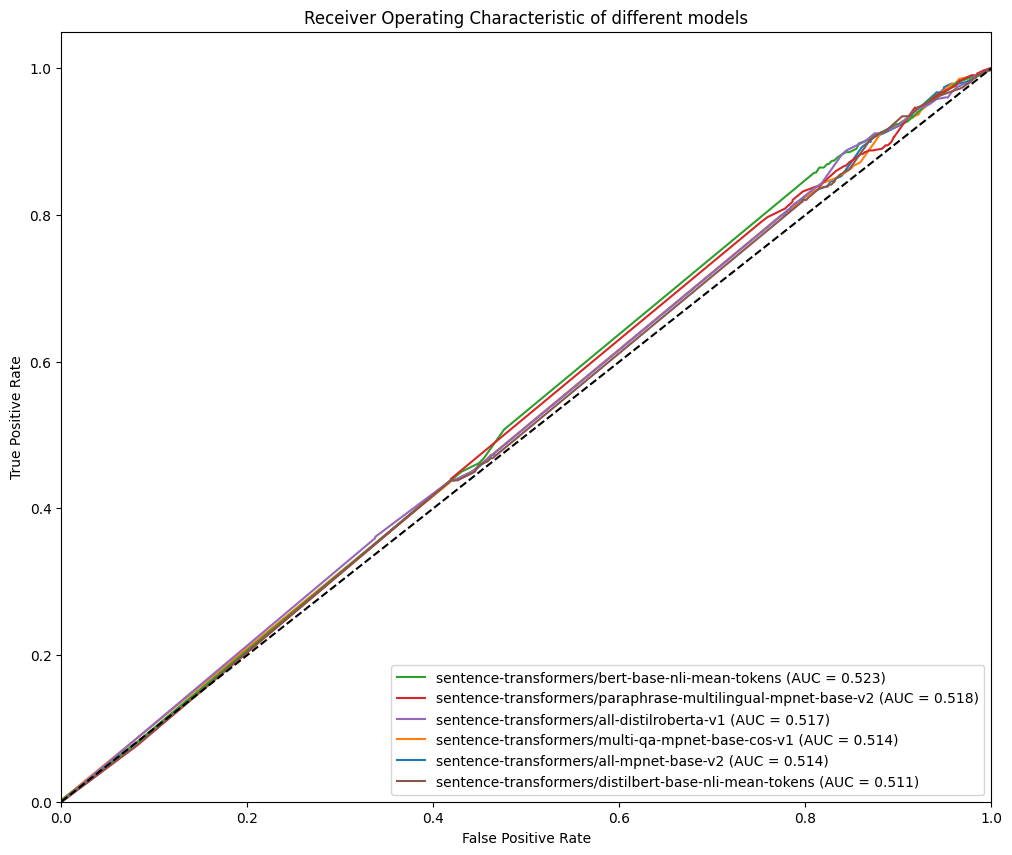

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_structure_evaluation_train_315.eps')
plt.show()

In [15]:
model_auc

{'sentence-transformers/all-mpnet-base-v2': 0.5138861193199707,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.5144395338680003,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5225956647141325,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.5175792027768531,
 'sentence-transformers/all-distilroberta-v1': 0.5166103053448543,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.5109808296382766}